In [1]:
import SimpleITK as sitk
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.io as io
from mpl_toolkits.mplot3d import Axes3D
import pywt


from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.measure import compare_psnr


In [2]:
#Defining customized fourier transform and inverse fourier transform, which were adopted from the MATLAB demo

def fft2c(x):
    fctr = x.shape[0]*x.shape[1]
    res = (1/np.sqrt(fctr))*(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x))))
       
    return res


def ifft2c(x):
    fctr = x.shape[0]*x.shape[1]

    res = (np.sqrt(fctr))*(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x))))
    
    return res

PDF surface plot :


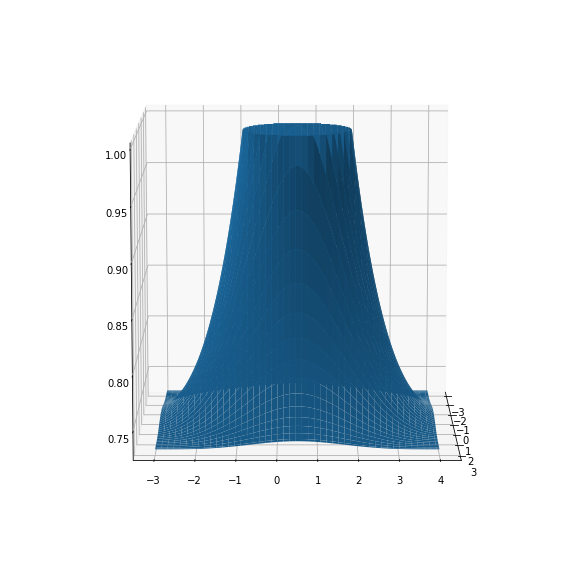

Noised Image :


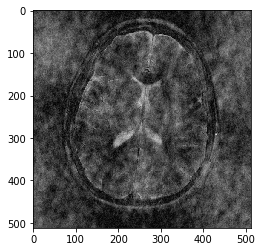

In [3]:
#Loading important data from demo database
mat = sci.io.loadmat('matlab_workspace.mat')
sci.io.whosmat('matlab_workspace.mat')
im_brain_ori= mat['im']


#TODO : Select sampling distribution pattern mask
default_mask= mat['mask_vardens']#default mask
random_mask = np.random.randint(2, size=(default_mask.shape[0],default_mask.shape[1]))#random mask for experiment
freq_mask = random_mask
#plt.imshow(abs(freq_mask),cmap = 'gray')
#plt.show()

#Defining default PDF
brain_pdf= mat['pdf_vardens']


#################SUBSTRACT PDF HEIGHT (OPTIONAL)##########################
#plt.imshow(flatten_pdf_1,cmap='bone')

N_subst = 0.5 #max 1.0
mod_pdf_1 = (brain_pdf-N_subst).clip(min=0.0000000005)


#################INCREASE PDF HEIGHT (OPTIONAL)##########################

max_pdf_cell = np.amax(brain_pdf)
N_add = 0.5
mod_pdf_2 = (brain_pdf+N_add).clip(max=max_pdf_cell)

#TODO : Change pdf set
pdf_set = mod_pdf_2 #brain_pdf is the default, or mod_pdf_2 or mod_pdf_1 for other setting


#####VISUALIZE PDF IN 3D#######
x_size = brain_pdf.shape[0]
y_size = brain_pdf.shape[1]
X = np.linspace(-3, 3, x_size)
Y = np.linspace(-3, 4, y_size)
hf = plt.figure(figsize=(10, 10))
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(X, Y)
print('PDF surface plot :')
ha.plot_surface(X, Y,pdf_set)
ha.view_init(10, 0)
plt.show()

####FIRST STAGE RECONSTRUCTION###########
fft_1=fft2c(im_brain_ori)
data_1 = np.multiply(fft_1,freq_mask)
data_1_weighted = np.divide(data_1,pdf_set)
ifft_1=ifft2c(data_1_weighted)
print('Noised Image :')
plt.imshow(abs(ifft_1),cmap = 'gray')
plt.show()




Noised Image, from first reconstruction :


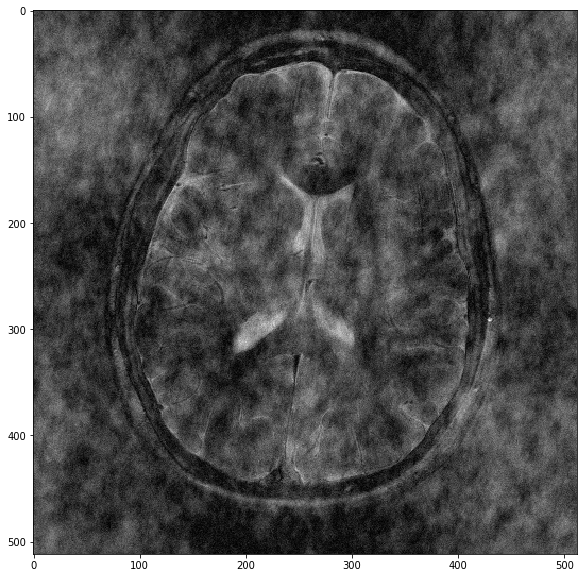

After
15
iterations


Reconstructed Image :


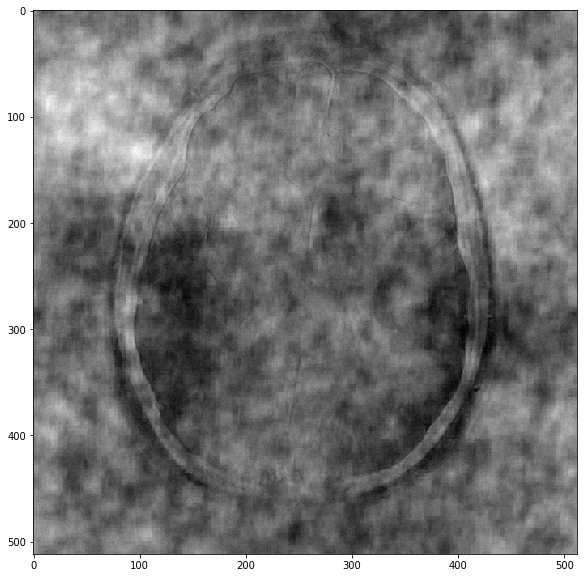

Original Image (cropped for comparison) :


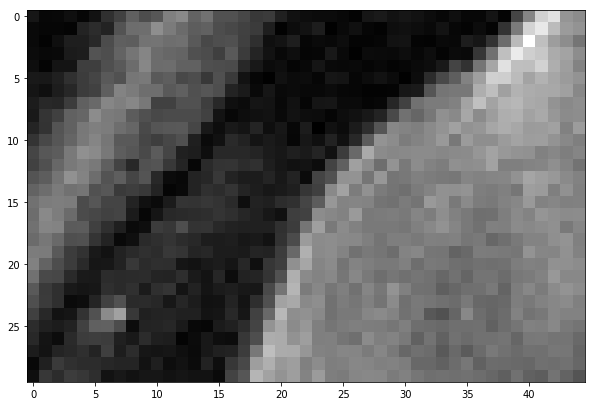

Noised Image (cropped for comparison) :


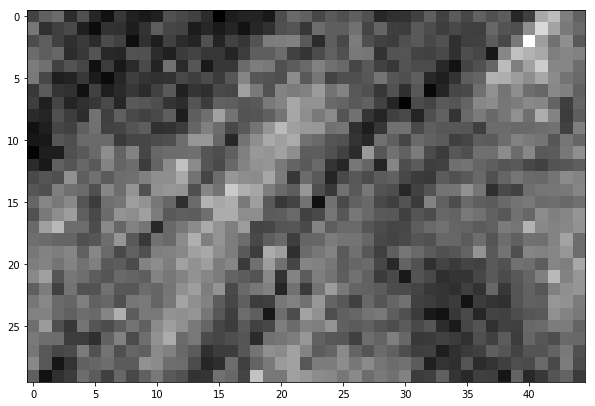

Reconstructed Image (cropped for comparison) :


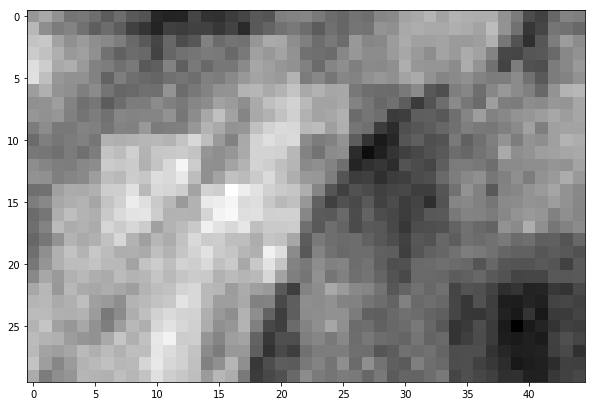

In [4]:
####SECOND STAGE RECONSTRUCTION###########
####USING ALTERNATIVE ALGORITHM###########


rct_1  = ifft_1

sigma_denoise = 0.05
denoise_iter = 15
denoise_iter_fix = denoise_iter
while denoise_iter > 0:
    denoise_iter = denoise_iter-1

    #TODO : Change thresholding approach##alternative algorithm
    rct_denoise = denoise_wavelet(abs(rct_1), mode='hard', sigma = sigma_denoise)
    
    rct_preprocess_1 = fft2c(rct_denoise)
    rct_preprocess_2 = (np.multiply(rct_preprocess_1,(1-freq_mask))) + data_1
    rct_postprocess =  ifft2c(rct_preprocess_2)
    rct_1 = rct_postprocess
   

print('Noised Image, from first reconstruction :')
fig = plt.figure(figsize=(10, 10))
plt.imshow(abs(ifft_1),cmap = 'gray')
plt.show()
print('After')
print(denoise_iter_fix - denoise_iter)
print('iterations')
print('\n')
print('Reconstructed Image :')
fig = plt.figure(figsize=(10, 10))
plt.imshow(abs(rct_1),cmap = 'gray')
plt.show()


print('Original Image (cropped for comparison) :')
#crop_2 = rct_1[90:125,100:275]
crop_3 = im_brain_ori[90:120,130:175]
fig = plt.figure(figsize=(10, 10))
plt.imshow(abs(crop_3),cmap = 'gray')
plt.show()

print('Noised Image (cropped for comparison) :')
#crop_1 = ifft_1[90:125,100:275]
crop_1 = ifft_1[90:120,130:175]
fig = plt.figure(figsize=(10, 10))
plt.imshow(abs(crop_1),cmap = 'gray')
plt.show()

print('Reconstructed Image (cropped for comparison) :')
#crop_2 = rct_1[90:125,100:275] 
crop_2 = rct_1[90:120,130:175]
fig = plt.figure(figsize=(10, 10))
plt.imshow(abs(crop_2),cmap = 'gray')
plt.show()